In [12]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# 2017.08.24

In [34]:
import numpy as np

from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.contrib.keras.python.keras.layers import Conv2D
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed
from tensorflow.contrib.keras.python.keras.models import model_from_json

import matplotlib.pyplot as plt

# Network parameters

In [51]:
np.random.seed(2016)  
batch_size = 128
nb_epochs = 1000
examplesPer = 60000
maxToAdd = 8
size = 28

# MNIST data

In [3]:
# the data, shuffled and split between train and test sets
(X_train_raw, y_train_temp), (X_test_raw, y_test_temp) = mnist.load_data()

#basic image processing
X_train_raw = X_train_raw.astype('float32')
X_test_raw  = X_test_raw.astype('float32')
X_train_raw /= 255
X_test_raw  /= 255

print('X_train_raw shape:', X_train_raw.shape)
print(X_train_raw.shape[0], 'train samples')
print(X_test_raw.shape[0], 'test samples')

X_train_raw shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

X_train = np.zeros((examplesPer, maxToAdd, size, size, 1))

for i in range(0, examplesPer):
    #initialize a training example of max_num_time_steps, im_size, im_size
    output = np.zeros((maxToAdd, size, size, 1))
    #decide how many MNIST images to put in that tensor
    numToAdd = int(np.ceil(np.random.rand()*maxToAdd))
    #sample that many images
    indices = np.random.choice(X_train_raw.shape[0], size=numToAdd)
    example = X_train_raw[indices]
    #sum up the outputs for new output
    exampleY = y_train_temp[indices]
    output[0:numToAdd,:,:,0] = example
    X_train[i, :, :, :, :] = output
    y_train.append(np.sum(exampleY))

y_train = np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

#Test the model
X_test = np.zeros((examplesPer, maxToAdd, size, size, 1))
for i in range(0, examplesPer):
    output = np.zeros((maxToAdd, size, size, 1))
    numToAdd = int(np.ceil(np.random.rand()*maxToAdd))
    indices = np.random.choice(X_test_raw.shape[0], size=numToAdd)
    example = X_test_raw[indices]
    exampleY = y_test_temp[indices]
    output[0:numToAdd,:,:,0] = example
    X_test[i, :, :, :, :] = output
    y_test.append(np.sum(exampleY))

X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (60000, 8, 28, 28, 1)
y_train shape:  (60000,)
X_test shape:  (60000, 8, 28, 28, 1)
y_test shape:  (60000,)


# Model: CNN + LSTM

In [52]:
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (4, 4), padding='valid'), input_shape=(maxToAdd, size, size, 1)))
model.add(Activation('relu'))
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='valid')))
model.add(Activation('relu'))
model.add(TimeDistributed(Flatten()))
model.add(Activation('relu'))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(.2))
model.add(Dense(1))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 8, 25, 25, 8)      136       
_________________________________________________________________
activation_22 (Activation)   (None, 8, 25, 25, 8)      0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 8, 23, 23, 16)     1168      
_________________________________________________________________
activation_23 (Activation)   (None, 8, 23, 23, 16)     0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 8, 8464)           0         
_________________________________________________________________
activation_24 (Activation)   (None, 8, 8464)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 100)         3426000   
__________

# Compile model

In [53]:
adam = Adam(lr=0.0001)
model.compile(loss='mean_absolute_error', optimizer=adam)

# Training

In [54]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=batch_size, epochs=nb_epochs, verbose=1,
          callbacks=[early_stopping])    

Train on 60000 samples, validate on 60000 samples
Epoch 1/1000
60000/60000 [==============================] - 41s - loss: 12.5210 - val_loss: 10.3359
Epoch 2/1000
60000/60000 [==============================] - 38s - loss: 9.5628 - val_loss: 8.6996
Epoch 3/1000
60000/60000 [==============================] - 38s - loss: 8.1235 - val_loss: 7.3811
Epoch 4/1000
60000/60000 [==============================] - 38s - loss: 6.9277 - val_loss: 6.2561
Epoch 5/1000
60000/60000 [==============================] - 38s - loss: 5.9354 - val_loss: 5.3330
Epoch 6/1000
60000/60000 [==============================] - 37s - loss: 5.1161 - val_loss: 4.5804
Epoch 7/1000
60000/60000 [==============================] - 38s - loss: 4.4261 - val_loss: 3.9840
Epoch 8/1000
60000/60000 [==============================] - 38s - loss: 3.8701 - val_loss: 3.3904
Epoch 9/1000
60000/60000 [==============================] - 38s - loss: 3.4024 - val_loss: 2.9480
Epoch 10/1000
60000/60000 [==============================] - 38s -

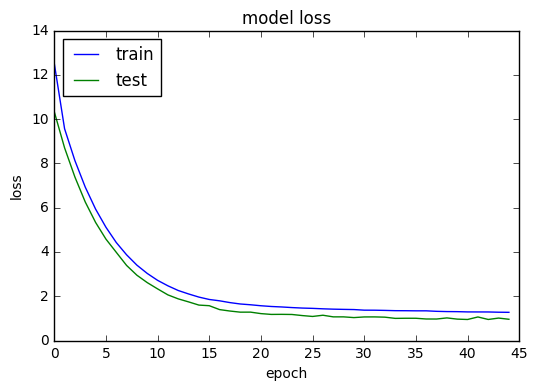

In [55]:
history_ = history.history
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing

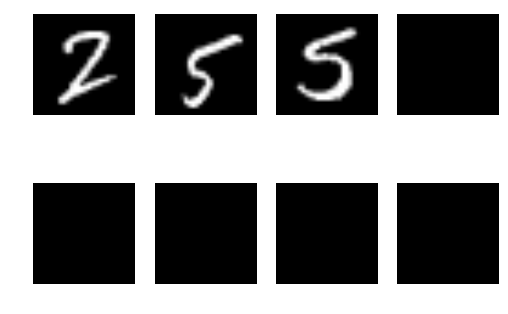

12 ~ 12.3572


In [56]:
indx = int(np.ceil(np.random.rand()*examplesPer))
test_ins = X_test[indx]

img_indx = 0
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

img_indx += 1
plt.subplot(2, 4, img_indx + 1)
plt.axis('off')
plt.imshow(X_test[indx][img_indx][:, :, 0], cmap='gray')

plt.show()

test_ins = np.expand_dims(test_ins, axis=0)

preds = model.predict(test_ins)
print(str(y_test[indx]) + ' ~ ' + str(preds[0][0]))